# Set kernel to: `Python 3`
If this kernel is not available, see the Kernel Installation Instructions section located in at the bottom of this Notebook.

# Data Science on the C3 AI Suite
## C3DS - Natural Language Processing
#### For questions, comments, or concerns, please email C3 Training Team \< training@c3.ai \>, discuss with your instructor, or leave your thoughts in the Google Forms at the end of this module.

## Exercise Goal

<b>Objective: </b>This notebook is about **implementing natural language processing (NLP) on the platform**.  You will be introduced to fundamental building blocks of NLP in C3, right from the relevant data types to highly functional pipes. Our primary focus will be centered around understanding the available NLP pipes, their role with respect to the data preparation for machine learning, and code implementation via examples.  Our end goal is to use the C3 Natural Language Processing and Machine Learning Pipelines to build an end-to-end pipeline to classify spam messages.
    
<b>Use Case: </b> The use case for this tutorial will be classifying spam messages. A dataset in the starter package has been provided for the same. More details about loading the dataset can be found in [Section 1.A](#1a)


- In Section 1, we load, and produce the training and testing data set. In addition, we introduce three extremely important C3 NLP pipes for **text processing** - `TextSubstitutionPipe`, `SpacyPipe` and `CorpusToTextPipe`. Before we actually deep dive into the NLP pipes, we do a high level overview of NLP data types in C3, as understanding them will give us a better idea of how to structure a pipe's input, and process its output, based on its data type. We explore some of the many functionalities of these pipes with some examples, and then create the same to preprocess our dataset as an exercise. The `SpacyPipe` module (which also contains details of `CorpusToTextPipe`) for this section will be optional. However, we strongly encourage you to explore the spacy library if you haven't already, and then implement the optional modules in this section. This section has 3 mandatory and 1 optional exercises.  


- In Section 2, we address one of the most important steps in building an NLP pipeline for machine learning - **vectorizing the text data**. We explore construction of some of the common vectorization techniques using `SklearnTextVectorizerPipe`, after which we look at training and processing the constructed pipe. As an exercise, we create a `SklearnTextVectorizerPipe` to vectorize our data. This section has 1 mandatory exercise.

    
- In Section 3, we use `MLSerialPipeline` to **create an nlp pipeline** that consists of all the work we did in sections 1 and 2. In addition, we use the `SklearnPipe` to create a Logistic Regression model for classification and integrate it with the previously constructed nlp pipeline into one `MLSerialPipeline`. The pipeline can then be trained and processed. This section has 3 mandatory exercises. 


- In Section 4, we evaluate the results of our model by looking at ROC curve and score distribution. 


> **NOTE**: At the end of sections 1 and 2 you will only create the required pipes for processing the dataset. These pipes will be integrated into one MLSerialPipeline for training and processing, in section 3. 

## Table of Contents

* [Section 1 - Load, Split and preprocess the Spam dataset](#1)

   * [A. Load the Dataset](#1a)
   * [B. Split the Dataset](#1b)
   * [C. Data preprocessing using TextSubstitutionPipe and spacy ](#1c)
       * [NLP Data Types](#1ca)
       * [Using TextSubstitutionPipe](#1cb)
       * [Using SpacyPipe [Optional]](#1cc)
   

* [Section 2 - Text Vectorization using SklearnTextVectorizerPipe](#2) 

   * [A. Dummy Dataset Preparation](#2a)
   * [B. Exploring SklearnTextVectorizerPipe](#2b)
   

* [Section 3 - Putting it all together into one MLSerialPipeline ](#3)
   
   * [A. Creating the Pipeline](#3a)
   * [B. Train the entire Pipeline](#3b)
   * [C. Process the entire Pipeline](#3c)
 

* [Section 4 - Results](#4)

   * [A. ROC Results](#4a)
   * [B. Score Distribution](#4b)
   
[Appendix - Kernel Installation Instructions](#apdx)

## Section 1 - Load, Split and preprocess the Spam dataset <a class="anchor" id="1"></a>
We will be using **SpamData.csv** provided in the starter package at `SpamData_PATH`. Please upload the dataset to this jupyter instance, so that we can load it using its relative path. The dataset has 5574 text messages. 

**Make sure you remove the dataset after you are done with the exercise.**

### A. Load the dataset <a class="anchor" id="1a"></a>

In [1]:
import pandas as pd
import io
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

#### Exercise
Upload the dataset to this jupyter instance, so that we can load it using its relative path, `SpamText.csv`.

The code skeleton has been provided below.

In [2]:
# Exercise
# Upload the data and enter its relative path below.
# Fill in the ???? blank with your answer

relative_file_path = "SpamData.csv"
with c3_open(relative_path=relative_file_path, mode="r", force_refresh=True) as f:
    spam_data_df = pd.read_csv(f, index_col=0, header=0)

In [8]:
#checking if the data has been loaded correctly
assert len(spam_data_df) == 5574

In [3]:
X = spam_data_df.text.tolist()
y_text = spam_data_df.label.tolist()

# Encode the label from str to numeric
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y_text)

### B. Split the data <a class="anchor" id="1b"></a>

We use 67% of the data for training and 33% for testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

We will use this data for training and processing our created MLSerialPipeline in [Section 3.B](#3b)

### C. Data preprocessing using TextSubstitutionPipe and spacy <a class="anchor" id="1c"></a>

We first introduce data types in C3 relevant to NLP, giving a very high level overview of `TextContent`, `TextCollection`, `NlpTextCorpus` and `SparseDataset`. For the purposes of this tutorial notebook, it is important to understand their respective positions in a NLP-ML pipeline, i.e. for which individual pipes they can be input or an output. 

We then explore some of the common text processing functionalities using `TextSubstitutionPipe` and showcase the ease of creating and processing such a pipe via examples. In addition, we also talk about combining multiple processing functionalities (called `TextSubstitutionOp`) into one `TextSubstitutionPipe`. Post that, we introduce the `SpacyPipe` and showcase some of the advanced text processing functionalities it offers. It is good practice to use the `TextSubstitutionPipe` for ease of use and the `SpacyPipe` for advanced functionality. 
The `SpacyPipe` module of this section is optional.

At the end of both subsections we create the respective pipes that will be integrated into our `MLSerialPipeline` in [Section 3.A](#3a).

### NLP Data types <a class="anchor" id="1ca"></a>

Let's first get familiar with the C3 types that can be components of an NLP pipeline.

### `TextContent`, `TextCollection`
1. **`TextContent`**: This is a representation of text with the following fields: 
  1. text: `string`
  1. language: `string`
1. **`TextCollection`**: A collection of `TextContent`. 
  1. Calling the `collectAll()` method materializes a list of `TextContent`: `[TextContent]`.
  1. A `TextCollection` is created using the `fromSpec()` method, which takes a `TextCollectionSpec` as input.
  1. We will see later on in this notebook that `TextCollection` is the input and output type for a `TextSubstitutionPipe`. It also acts as the input type for `SpacyPipe`, input type for `SklearnTextVectorizerPipe`, and output type for `CorpusToTextPipe`. 
1. **`NlpTextCorpus`**: The `NlpTextCorpus` holds a list of `NlpTextDocument`s, which represents a document processed by NLP operations. We will also see that the `NlpTextCorpus` type is the output of a `SpacyPipe` and input to a `CorpusToTextPipe`.
1. **`SparseDataset`**: Can be utilized by machine learning pipes for training. It is the output of a `SklearnTextVectorizerPipe`.

The following code snippet converts a list of strings into a `TextCollection`

In [5]:
string_collection = ['this', 'is a collection', 'of strings.']
text_collection = c3.TextCollection.fromStringList(string_collection)
text_collection

c3.TextCollection(
 m_objs=c3.Arry<TextContent>([c3.TextContent(text='this'),
          c3.TextContent(text='is a collection'),
          c3.TextContent(text='of strings.')]))

### Using TextSubstitutionPipe <a class="anchor" id="1cb"></a>

In this section, we will first go through some examples of how to use `TextSubstitutionPipe` on some dummy data. We will use different text process functionalities called `TextSubstitutionOp`s to clean the input dummy data in `TextCollection`s. We also showcase how to creae a `TextSubstitutionPipe` with multiple `TextSubstitutionOp`s. At the end of the section, as an exercise we create one `TextSubstitutionPipe` that integrates 4 desired`TextSubstitutionOp`s that will be integrated into the `MLSerialPipeline`, and used for preprocessing our spam data. 

The `TextSubstitutionPipe` requires a `TextSubstitutionTechnique` which defines a list of operations in `TextSubstitutionTechnique#ops`. All operations extend `TextSubstitutionOp` and define their own required parameters. Currently the following operations are available: `ConvertDatesOp`, `RemoveDigitsOp`, `RemoveSubstringsOp`, `ReplaceSubstringsOp`, `ReplaceByRegexOp`, `ConvertToAsciiOp`,  `ConvertToLowerOp`, `RemoveExtraWhitespacesOp` and `RemovePunctuationOp`.

We cover the following:

* [`ConvertToAsciiOp`](#ConvertToAsciiOp)
* [`ConvertToLowerOp`](#ConvertToLowerOp)
* [`RemoveExtraWhitespacesOp`](#RemoveExtraWhitespacesOp)
* [`RemovePunctuationOp`](#RemovePunctuationOp)

<a id='ConvertToAsciiOp'></a>
#### ConvertToAsciiOp
The `ConvertToAsciiOp` converts **Unicode** characters outside of ASCII range to their corresponding **ASCII** characters. It does this by decomposing unicode characters using the [NFKD](https://en.wikipedia.org/wiki/Unicode_equivalence#Normal_forms) form and then removing characters that are in the [Combining Diacritical Marks Block](https://www.fileformat.info/info/unicode/block/combining_diacritical_marks/list.htm). Characters outside of the [Basic Latin Block](https://en.wikipedia.org/wiki/Basic_Latin_(Unicode_block)) are removed.

Once the `TextSubstitutionPipe` is configured, we can directly call the `process` function to apply the transformation to the input.

> Note: The `TextSubstitutionPipe` accepts a `TextCollection` as input, and outputs the transformed `TextCollection`. The operations defined in the `TextSubstitutionTechnique` are applied to the text of each `TextContent` in the input.

For convenience, we will define a function to convert a list of `string` to a `TextCollection`.

In [6]:
#create a text_substitution_pipe with onvertToAsciiOp()
text_substitution_pipe = c3.TextSubstitutionPipe(technique=c3.TextSubstitutionTechnique(
                            ops=[c3.ConvertToAsciiOp()]))
text_substitution_pipe

c3.TextSubstitutionPipe(
 noTrainScore=False,
 untrainableOverride=False,
 technique=c3.TextSubstitutionTechnique(
             ops=c3.Arry<TextSubstitutionOp>([c3.ConvertToAsciiOp()])))

In [7]:
# process dummy input using the created pipe
input_string_list = ['¡HELLO THERÉ! :)']
output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='HELLO THERE! :)')])

<a id='ConvertToLowerOp'></a>
#### ConvertToLowerOp
The `ConvertToLowerOp` replaces any uppercase Unicode character to its lowercase equivalent. All other characters are ignored. 

In [8]:
text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[c3.ConvertToLowerOp()]))

output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='¡hello theré! :)')])

<a id='RemovePunctuationOp'></a>
#### RemovePunctuationOp
The `RemovePunctuationOp` is used to remove [ASCII Punctuation](http://www.kerryr.net/pioneers/ascii3.htm), [Unicode General Punctuation](https://unicode-table.com/en/blocks/general-punctuation/), and [Unicode Supplemental Punctuation](https://unicode-table.com/en/blocks/supplemental-punctuation/). All occurences will be removed.

In [9]:
text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[c3.RemovePunctuationOp()]))

output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='¡HELLO THERÉ ')])

<a id='RemoveExtraWhitespacesOp'></a>
#### RemoveExtraWhitespacesOp
`RemoveExtraWhitespacesOp` can be used to merge consecutive whitespace characters into a single space. 

In [10]:
text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[c3.RemoveExtraWhitespacesOp()]))
input_string_list = ['Hello \t\nBob ']
output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='Hello Bob')])

By default, whitespaces that occur at the beginning and the end of strings are stripped. By specifying the `noStripText` flag to `True`, the whitespaces can be preserved. Note that multiple whitespaces will still be merged. Complete this as an exercise below.

#### Exercise
Create a TextSubstitutionPipe that removes all whitespaces except at the beginning and end of string.

The code skeleton has been provided below.

In [11]:
#Exercise
#Create a TextSubstitutionPipe that removes all whitespaces except at the beginning and end of string
# Fill in the ???? blank with your answer

text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[c3.RemoveExtraWhitespacesOp(
                                noStripText=True)]))
input_string_list = ['Hello \t\nBob ']
output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='Hello Bob ')])

#### Combining `TextSubstitutionOp`s

Multiple `TextSubstitutionOp`s  can be chained together to specify the sequence of preprocessing steps. This is done by specifying the `TextSubstitutionOp`s on `TextSubstitutionTechnique#ops` in the order that they should be executed. 

Let's take an example where our input is a simple chat message log:

`[12/31/2019 	 11PM 	 (Solo, Han): HAPPY NEW YEAR', 
'01/01/2020 	 8AM 	 (Organa, Leia): hiya! ☺️]`

In [6]:
lower = c3.ConvertToLowerOp()
punc = c3.RemovePunctuationOp()
rep_substrings = c3.ReplaceSubstringsOp(replacements={"hiya": "hello", "☺️":':)'}, flags=['i'])
date = c3.ConvertDatesOp(fromFormat='%m/%d/%Y', toFormat='%b %d:')
units = c3.RemoveDigitsOp(includeUnits=True, units=['AM', 'PM'], flags=['i'])
regex = c3.ReplaceByRegexOp(regex=r'\((\w+), (\w+)\)\:', replace=r'(\2 \1) ')
ws = c3.RemoveExtraWhitespacesOp(noStripText=False)

text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[lower, rep_substrings, date, units, regex, ws]))

In [13]:
input_string_list = ['12/31/2019 	 11PM 	 (Solo, Han): HAPPY NEW YEAR', '01/01/2020 	 8AM 	 (Organa, Leia): hiya! ☺️']
output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
output

c3.Arry<TextContent>([c3.TextContent(text='Dec 31: (han solo) happy new year'),
 c3.TextContent(text='Jan 01: (leia organa) hello! :)')])

As we can see, our output does indeed match what we expected!

#### Exercise

Create a `TextSubstitutionPipe` that does the following four operations:
* ConvertToAsciiOp
* ConvertToLowerOp
* RemovePunctuationOp
* RemoveExtraWhitespacesOp

The code skeleton has been provided below.

**We will use this pipe for processing our data later in the notebook.**

In [7]:
#Exercise
#Create a TextSubstitutionPipe with the operations mentioned above
# Fill in the ???? blank with your answer
asciiop = c3.ConvertToAsciiOp()

text_substitution_pipe = c3.TextSubstitutionPipe(
                        technique=c3.TextSubstitutionTechnique(
                            ops=[asciiop, lower, punc, ws]))
# input_string_list = ['Hello \t\nBob ', '¡HELLO THERÉ! :)'] ###add more strings
# output = text_substitution_pipe.process(input=c3.TextCollection.fromStringList(input_string_list)).collectAll()
# output

### Using SpacyPipe [Optional] <a class="anchor" id="1cc"></a>

In this section, we show how to use `SpacyPipe`, and `CorpusToTextPipe` to do natural language processing with the [spaCy](https://spacy.io/) library. If you are not familiar with this library, you can refer to the following link: [spaCy 101](https://spacy.io/usage/spacy-101)

You will learn how to:
1. Configure/set `SpacyTechnique` on the `SpacyPipe`.
1. Construct a `SpacyPipe` and use it for processing text.
1. Use `CorpusToTextPipe` to process the output of `SpacyPipe`, to remove and replace substrings whose corresponding tokens have certain attributes.

#### Configure Spacy Technique

In [42]:
spacy_technique = c3.SpacyTechnique(components=["ner", "tagger"], # components to be added to pipeline
                                    # ner stands for 'named entity recogition'
                                    # tagger refers to Part of Speech Tagger
                                    language=c3.SpacyLanguageModel.EN, # Language model
                                    containsWordEmbeddings=False, # Whether to generate word embeddings for the tokens
                                   )


#### Add Patterns to the *spaCy* Matcher

`SpacyTechnique.matcherPatterns` finds the text that matches the **pattern** by invoking the `spacy.matcher.add()` method . This **matched text** is then stored in `NlpTextDocument.matchedPatterns`. The patterns can refer to Spacy **token annotations** (e.g. the token text, attributes like `IS_PUNCT`). You can also associate patterns with entity ids, to allow some basic entity linking or disambiguation.

`SpacyTechnique.matcherPatterns` is a collection of `SpacyMatcherPattern`s.  Each `SpacyMatcherPattern` consists of a 
1. `matchId`: unique identifier for each pattern. Later used by `CorpusToTextPipe` to remove/replace the matched text based on this id.
1. `patterns`: consists of one or several lists of maps, where each map describes a Spacy token.

For the purpose of this tutorial, we will configure the `SpacyPipe` to perform the following operations:

1. Find stop words
1. Find all the words whose named entity is `ORG`.
1. Find all occurrences where `United States` is misspelled.

In [43]:
# matcher pattern for finding all stop words
remove_stop = c3.SpacyMatcherPattern(matchId='removeStop', 
                                           patterns=([[{'IS_STOP': True}]]))
# matcher pattern for finding all the words whose named entity is ORG
replace_org = c3.SpacyMatcherPattern(matchId='replaceOrg', 
                                     patterns=([[{'ENT_TYPE': 'ORG'}]]))
# matcher pattern for finding all occurrences where United States is misspelled
misspelled = c3.SpacyMatcherPattern(matchId='misspelled', 
                                    patterns=([[{"TEXT": {"REGEX": "^[Uu](?!.*(.).*\1)[nited]*$"}},
                                                {"TEXT": {"REGEX": "^[Ss](?!.*(.).*\1)[tates]*$"}}]]))

In [44]:
spacy_technique.matcherPatterns=[remove_stop, 
                                 replace_org, 
                                 misspelled,
                                ]

#### Construct and Process a `SpacyPipe` on dummy data

A `SpacyPipe` takes in a `TextCollection` as input which is a collection of `TextContent`, and returns a `NlpTextCorpus` as output. `TextContent` stores the text data and any metadata associated with it like the language, etc. A `NlpTextCorpus` is a collection of `NlpTextDocument`s containing linguistic features like **part-of-speech tags**, **named-entities** and **lexemes** which stores context-independent information such as the root word and word embeddings.

In [19]:
pip install --upgrade pip

     |████████████████████████████████| 1.5MB 4.1MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Note: you may need to restart the kernel to use updated packages.


In [45]:
# snippet errors out. see https://c3energy.atlassian.net/browse/DATA-4420
# Construct a SpacyPipe
spacy_pipe = c3.SpacyPipe(name="spacy",
                          technique=spacy_technique)

# Process a SpacyPipe
input_text = ["<< Let's try some custom--tokenization. It should not split intra-hyphenated words .>>",
              "Phone numbers like (123) 456 789 as well as stop words should be removed.",
              "Companies like Apple should be replaced with 'ORG'.",
              "Words like said and saying whose root word is say should be replaced by their root word.",
              "Misspelled words like Uinted Satets should be spelt correctly.",
              "Emojis with positive sentiments like 😀 and 😃 should be replaced by happy.",
              "Emojis with negative sentiments like 😞 and 😠 should be replaced by sad."]

corpus = spacy_pipe.process(input=c3.TextCollection.fromStringList(input_text))
corpus

500 - NotClassified - c3.engine.action.CondaActionRuntimeMethods_installRuntime [3026.505963]
message: "Failed during the creation of ActionRuntime 'Obj<ActionRuntime> [name=py-spacy,id=py-spacy]', a_step='environment creation', a_error='c3.love.exceptions.C3RuntimeException: Error executing command: [/usr/local/share/c3/conda/bin/conda, env, create, -p, /usr/local/share/c3/condaEnvs/c3training/dev16/py-spacy, -q, --file, /tmp/c46fbb1d-21f2-43b9-a6c7-e189c6c2aa1b/requirements.yaml]
Pip subprocess error:
Could not install packages due to an EnvironmentError: [Errno 28] No space left on device
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
CondaEnvException: Pip failed'"
JSON: {"this": {"type": "SpacyPipe", "name": "spacy", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "SpacyTechnique", "components": ["ner", "tagger"], "language": "en", "containsWordEmbeddings":

C3RuntimeException: 500 - NotClassified - c3.engine.action.CondaActionRuntimeMethods_installRuntime [3026.505963]
message: "Failed during the creation of ActionRuntime 'Obj<ActionRuntime> [name=py-spacy,id=py-spacy]', a_step='environment creation', a_error='c3.love.exceptions.C3RuntimeException: Error executing command: [/usr/local/share/c3/conda/bin/conda, env, create, -p, /usr/local/share/c3/condaEnvs/c3training/dev16/py-spacy, -q, --file, /tmp/c46fbb1d-21f2-43b9-a6c7-e189c6c2aa1b/requirements.yaml]
Pip subprocess error:
Could not install packages due to an EnvironmentError: [Errno 28] No space left on device
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
CondaEnvException: Pip failed'"
JSON: {"this": {"type": "SpacyPipe", "name": "spacy", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "SpacyTechnique", "components": ["ner", "tagger"], "language": "en", "containsWordEmbeddings": false, "matcherPatterns": [{"type": "SpacyMatcherPattern", "matchId": "removeStop", "patterns": {"type": "[[map<string,any>]]", "value": [[{"IS_STOP": {"type": "boolean", "value": true}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "replaceOrg", "patterns": {"type": "[[map<string,any>]]", "value": [[{"ENT_TYPE": {"type": "string", "value": "ORG"}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "misspelled", "patterns": {"type": "[[map<string,any>]]", "value": [[{"TEXT": {"type": "json", "value": {"REGEX": "^[Uu](?!.*(.).*\u0001)[nited]*$"}}}, {"TEXT": {"type": "json", "value": {"REGEX": "^[Ss](?!.*(.).*\u0001)[tates]*$"}}}]]}}]}}, "input": {"type": "TextCollection", "m_objs": [{"type": "TextContent", "text": "<< Let's try some custom--tokenization. It should not split intra-hyphenated words .>>"}, {"type": "TextContent", "text": "Phone numbers like (123) 456 789 as well as stop words should be removed."}, {"type": "TextContent", "text": "Companies like Apple should be replaced with 'ORG'."}, {"type": "TextContent", "text": "Words like said and saying whose root word is say should be replaced by their root word."}, {"type": "TextContent", "text": "Misspelled words like Uinted Satets should be spelt correctly."}, {"type": "TextContent", "text": "Emojis with positive sentiments like \ud83d\ude00 and \ud83d\ude03 should be replaced by happy."}, {"type": "TextContent", "text": "Emojis with negative sentiments like \ud83d\ude1e and \ud83d\ude20 should be replaced by sad."}]}, "spec": null}

#### Clean up Text Using `CorpusToTextPipe`

`CorpusToTextPipe` can be used here to perform text preprocessing tasks such as tokenization, removal of stop words, replacing words with their lemma, etc. It takes a `NlpTextCorpus` as input and returns a `TextCollection` which is a collection of **filtered text content** from all the `NlpTextDocument`s present in that corpus. It uses the information present in `NlpTextDocument.matchedPatterns` to filter text from the `NlpTextDocument.text`.

To **replace** or **remove** the text, configure `CorpusToTextTechnique.matchedPatternReplacements`. `CorpusToTextTechnique.matchedPatternReplacements` is a map which consists of **matchId** as key and **"how to act on the matched text"** as the value. These **matchId**s **should match** the `SpacyMatcherPattern.matchId` configured in the `SpacyPipe`.

In [21]:
# Configure CorpusToTextTechnique 

# Keys should match the SpacyMatcherPattern.matchId configured in the SpacyPipe
match_replacements = {"removeStop": "", # Remove all occurences of stop words and phone numbers
                      "replaceOrg": "ORG", # Replace all words with named entity "ORG" with "ORG"
                      "misspelled": "United States"} # Correct all misspelled occurences of United States
technique = c3.CorpusToTextTechnique(matchedPatternReplacements=match_replacements,
                                     doNotDeleteInputCorpus=True)

# Create the pipe
corpus_to_text_pipe = c3.CorpusToTextPipe(name="filterText", technique=technique)

# Process the pipe
filtered_text = corpus_to_text_pipe.process(input=corpus)

**Note**: `CorpusToTextPipe` by default deletes the persisted input `NlpTextCorpus`. This means if you want to reuse the persisted corpus, you should either set the flag `CorpusToTextTechnique.doNotDeleteInputCorpus` to `true` or create a copy of the corpus before passing it to this pipe.

Now, let's compare the **original text** with the **output** of `CorpusToTextPipe`:

In [22]:
filtered_text_objs = filtered_text.collectAll()
for i, original_text in enumerate(input_text):
    print("original_text: " + original_text)
    print("filtered_text: " + filtered_text_objs[i].text)
    print("\n")

original_text: << Let's try some custom--tokenization. It should not split intra-hyphenated words .>>
filtered_text: << Let try  custom--tokenization.    split intra-hyphenated words .>>


original_text: Phone numbers like (123) 456 789 as well as stop words should be removed.
filtered_text: Phone numbers like (123) 456 789    stop words   removed.


original_text: Companies like Apple should be replaced with 'ORG'.
filtered_text: Companies like ORG   replaced  'ORG'.


original_text: Words like said and saying whose root word is say should be replaced by their root word.
filtered_text: Words like said  saying  root word     replaced   root word.


original_text: Misspelled words like Uinted Satets should be spelt correctly.
filtered_text: Misspelled words like United States   spelt correctly.


original_text: Emojis with positive sentiments like 😀 and 😃 should be replaced by happy.
filtered_text: Emojis  positive sentiments like 😀  😃   replaced  happy.


original_text: Emojis with neg

#### Exercise [Optional]

Create a `SpacyPipe` and `CorpusToTextPipe` that does the following:
1. Identify stop words and remove them
2. Identify email addresses and replace with 'email'
3. Identify URLs and replace with 'http'
4. Identify numbers and replace with 'number'
5. Identify named entity of `ORG` and replace with 'organisation'

The code skeleton has been provided below.

**We can use thess pipes for processing our data later in the notebook. It is not mandatory**

In [37]:
#Exercise
#Create a SpacyPipe that matches the patterns mentioned above
# Fill in the ???? blank with your answer

spacy_technique = c3.SpacyTechnique(
    components=['ner', "tagger"],
    language=c3.SpacyLanguageModel.EN,
    containsWordEmbeddings=False
)

remove_stop_words_pattern = c3.SpacyMatcherPattern(matchId="stopWord",
                                                   patterns=([[{'IS_STOP': True}]]))
remove_num_pattern = c3.SpacyMatcherPattern(matchId="likeNum",
                                            patterns=([[{"LIKE_NUM": True}]]))
remove_url_pattern = c3.SpacyMatcherPattern(matchId="likeUrl",
                                            patterns=([[{"LIKE_URL": True}]]))
remove_email_pattern = c3.SpacyMatcherPattern(matchId="likeEmail",
                                              patterns=([[{"LIKE_EMAIL": True}]]))
remove_named_entity = c3.SpacyMatcherPattern(matchId="isOrg",
                                             patterns=([[{"ENT_TYPE": "ORG"}]]))

spacy_technique.matcherPatterns = [
    remove_stop_words_pattern,
    remove_num_pattern,
    remove_url_pattern,
    remove_email_pattern,
    remove_named_entity]

spacy_pipe = c3.SpacyPipe(technique=spacy_technique)


In [38]:
input_text = ["<< Let's try some custom--tokenization. It should not split intra-hyphenated words .>>",
              "Phone numbers like (123) 456 789 as well as stop words should be removed.",
              "Companies like Apple should be replaced with 'ORG'.",
              "Words like said and saying whose root word is say should be replaced by their root word.",
              "Misspelled words like Uinted Satets should be spelt correctly.",
              "Emojis with positive sentiments like 😀 and 😃 should be replaced by happy.",
              "Emojis with negative sentiments like 😞 and 😠 should be replaced by sad."]

corpus = spacy_pipe.process(input=c3.TextCollection.fromStringList(input_text))
corpus

500 - NotClassified - c3.engine.action.CondaActionRuntimeMethods_installRuntime [3589.278613]
message: "Failed during the creation of ActionRuntime 'Obj<ActionRuntime> [name=py-spacy,id=py-spacy]', a_step='environment creation', a_error='c3.love.exceptions.C3RuntimeException: Error executing command: [/usr/local/share/c3/conda/bin/conda, env, create, -p, /usr/local/share/c3/condaEnvs/c3training/dev16/py-spacy, -q, --file, /tmp/b29b2a2a-4b46-4b76-a0bc-3d5177cfa2e9/requirements.yaml]
Pip subprocess error:
Could not install packages due to an EnvironmentError: [Errno 28] No space left on device
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
CondaEnvException: Pip failed'"
JSON: {"this": {"type": "SpacyPipe", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "SpacyTechnique", "components": ["ner", "tagger"], "language": "en", "containsWordEmbeddings": false, "matcherP

C3RuntimeException: 500 - NotClassified - c3.engine.action.CondaActionRuntimeMethods_installRuntime [3589.278613]
message: "Failed during the creation of ActionRuntime 'Obj<ActionRuntime> [name=py-spacy,id=py-spacy]', a_step='environment creation', a_error='c3.love.exceptions.C3RuntimeException: Error executing command: [/usr/local/share/c3/conda/bin/conda, env, create, -p, /usr/local/share/c3/condaEnvs/c3training/dev16/py-spacy, -q, --file, /tmp/b29b2a2a-4b46-4b76-a0bc-3d5177cfa2e9/requirements.yaml]
Pip subprocess error:
Could not install packages due to an EnvironmentError: [Errno 28] No space left on device
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
CondaEnvException: Pip failed'"
JSON: {"this": {"type": "SpacyPipe", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "SpacyTechnique", "components": ["ner", "tagger"], "language": "en", "containsWordEmbeddings": false, "matcherPatterns": [{"type": "SpacyMatcherPattern", "matchId": "stopWord", "patterns": {"type": "[[map<string,any>]]", "value": [[{"IS_STOP": {"type": "boolean", "value": true}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "likeNum", "patterns": {"type": "[[map<string,any>]]", "value": [[{"LIKE_NUM": {"type": "boolean", "value": true}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "likeUrl", "patterns": {"type": "[[map<string,any>]]", "value": [[{"LIKE_URL": {"type": "boolean", "value": true}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "likeEmail", "patterns": {"type": "[[map<string,any>]]", "value": [[{"LIKE_EMAIL": {"type": "boolean", "value": true}}]]}}, {"type": "SpacyMatcherPattern", "matchId": "isOrg", "patterns": {"type": "[[map<string,any>]]", "value": [[{"ENT_TYPE": {"type": "string", "value": "ORG"}}]]}}]}}, "input": {"type": "TextCollection", "m_objs": [{"type": "TextContent", "text": "<< Let's try some custom--tokenization. It should not split intra-hyphenated words .>>"}, {"type": "TextContent", "text": "Phone numbers like (123) 456 789 as well as stop words should be removed."}, {"type": "TextContent", "text": "Companies like Apple should be replaced with 'ORG'."}, {"type": "TextContent", "text": "Words like said and saying whose root word is say should be replaced by their root word."}, {"type": "TextContent", "text": "Misspelled words like Uinted Satets should be spelt correctly."}, {"type": "TextContent", "text": "Emojis with positive sentiments like \ud83d\ude00 and \ud83d\ude03 should be replaced by happy."}, {"type": "TextContent", "text": "Emojis with negative sentiments like \ud83d\ude1e and \ud83d\ude20 should be replaced by sad."}]}, "spec": null}

In [ ]:
match_replacements = {
    "remove_stop_words_pattern": "",
    "remove_num_pattern": "number",
    "remove_url_pattern": "http",
    "remove_email_pattern": "email",
    "remove_named_entity": "ORG"
    
}
technique = c3.CorpusToTextTechnique(matchedPatternReplacements=match_replacements,
                                     doNotDeleteInputCorpus=True)
# Create the pipe
corpus_to_text_pipe = c3.CorpusToTextPipe(name="filterText", technique=technique)

# Process the pipe
filtered_text = corpus_to_text_pipe.process(input=corpus)

## Section 2 - Text Vectorization using SklearnTextVectorizerPipe <a class="anchor" id="2"></a>


`SklearnTextVectorizerPipe` takes in a `TextCollection` as input data and returns a `SparseDataset` as output.
The text vectorization technique can be specified through an `MLTechnique` on the `SklearnTextVectorizerPipe#technique` field. The `SparseDataset` output can be converted into dense data using `c3.DensifyDatasetPipe()` for input to a `SklearnPipe`. We see this in action later in the notebook.

The `MLTechnique#name` can be any of the following functions (from the *scikit-learn* submodule [feature_extraction.text](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)).

* `CountVectorizer`: Convert a collection of text documents to a matrix of token counts.
* `HashingVectorizer`: Convert a collection of text documents to a matrix of token occurrences.
* `TfidfVectorizer`: Convert a collection of raw documents to a matrix of TF-IDF features.

### A. Dummy Dataset Preparation <a class="anchor" id="2a"></a>

In [24]:
#create dummy data to show the functionality of SklearnTextVectorizerPipe
train_text = [
    "apple banana pear",
    "cherry banana apple", 
    "pineapple cherry pear",
    "strawberry pineapple blueberry",
    "raspberry banana pear",
    "apple watermelon raspberry",
    "watermelon strawberry blueberry",
    "pineapple banana banana",
    "peach pineapple banana",
    "peach pear peach peach"
]

test_text = [
    "peach peach peach peach",
    "cherry cherry cherry peach mongo", 
    "banana banana banana",
    "watermelon watermelon watermelon",
    "pineapple pineapple pineapple",
]

`TextCollection` is a collection of `TextContent`. The `TextCollection` can be constructed directly from a list of strings by using the `TextCollection#fromStringList` function.

In [25]:
train_text_collection = c3.TextCollection.fromStringList(train_text)
test_text_collection = c3.TextCollection.fromStringList(test_text)

### B. Exploring `SklearnTextVectorizerPipe` <a class="anchor" id="2b"></a>

#### Construct the `SklearnTextVectorizerPipe` by using `CountVectorizer`
We will need to create an instance of `MLTechnique` whose name is `CountVectorizer` and then pass this technique into the `SklearnTextVectorizerPipe`.

In [26]:
sklearn_technique_count = c3.MLTechnique(name="CountVectorizer")
sklearn_text_vectorizer_pipe_count = c3.SklearnTextVectorizerPipe(technique=sklearn_technique_count)

#### Construct the `SklearnTextVectorizerPipe` by using `TfidfVectorizer`

We can also create an instance of `MLTechnique` with the name `TfidfVectorizer`. Here we will specify a hyper parameter to not normalize the results.

In [27]:
sklearn_technique_tfidf = c3.MLTechnique(name="TfidfVectorizer", hyperParameters={"norm": None})
sklearn_text_vectorizer_pipe_tfidf = c3.SklearnTextVectorizerPipe(technique=sklearn_technique_tfidf)

#### Train `SklearnTextVectorizerPipe`
We can now train the pipe by calling `SklearnTextVectorizerPipe#train`.

In [28]:
sklearn_text_vectorizer_pipe_count = sklearn_text_vectorizer_pipe_count.train(train_text_collection)

#### Process the `SklearnTextVectorizerPipe`
Finally, we can process those 3 trained pipes by calling `SklearnTextVectorizerPipe#process`.
> **NOTE**: `CountVectorizer` and `HashingVectorizer` are not dependent on the training dataset.

In [29]:
test_sparse_dataset_count = sklearn_text_vectorizer_pipe_count.process(test_text_collection)

To visualize the processed data we will need to use the `SparseDataset#densify` function to convert it to `Dataset`. Finally we can use the `Dataset#toPandas` function to convert it to *pandas* DataFrame.

In [30]:
c3.Dataset.toPandas(test_sparse_dataset_count.densify())

apple  banana  blueberry  cherry  peach  pear  pineapple  raspberry  \
0    0.0     0.0        0.0     0.0    4.0   0.0        0.0        0.0   
1    0.0     0.0        0.0     3.0    1.0   0.0        0.0        0.0   
2    0.0     3.0        0.0     0.0    0.0   0.0        0.0        0.0   
3    0.0     0.0        0.0     0.0    0.0   0.0        0.0        0.0   
4    0.0     0.0        0.0     0.0    0.0   0.0        3.0        0.0   

   strawberry  watermelon  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         3.0  
4         0.0         0.0

#### Exercise

Create a `SklearnTextVectorizerPipe` using TfidfVectorizer

The code skeleton has been provided below.

**We will use this pipe for vectorizing our data later in the notebook.**

In [9]:
#Exercise
#Create a SklearnTextVectorizerPipe using TfidfVectorizer
# Fill in the ???? blank with your answer

sklearn_technique = c3.MLTechnique(name="TfidfVectorizer", hyperParameters={"norm": None})
sklearn_text_vectorizer_pipe = c3.SklearnTextVectorizerPipe(technique=sklearn_technique)

## Section 3 - Putting it all together into one MLSerialPipeline <a class="anchor" id="3"></a>

### A. Create the Pipeline <a class="anchor" id="3a"></a>

**Exercise**

In case you haven't done the [SpacyPipe](#2cb) module, you will not have a `spacy_pipe` and a `corpus_to_text_pipe`created. In that case create a `nlpPipeline` with only `text_substitution_pipe` and `sklearn_text_vectorizer_pipe`. The code skeleton for the same has been given to you in the cell.

If you have completed the module, create a `nlpPipeline` that consists of the previously created `text_substitution_pipe`, `spacy_pipe`, `corpus_to_text_pipe` and `sklearn_text_vectorizer_pipe`. The code skeleton for the same has been given to you in the cell.

In [10]:
#Exercise
#Complete either A or B

#A
#Create the entire nlp pipeline without spacy_pipe and corpus_to_text_pipe
#Fill in the ???? blank with your answer

# nlpPipeline = c3.MLSerialPipeline(
#     name="nlp",
#     steps=[
#         c3.MLStep(name="substitution",
#                   pipe=text_substitution_pipe),
#         c3.MLStep(name="vectorizer",
#                   pipe=sklearn_text_vectorizer_pipe),
#     ]
# )


#B
#Create the entire nlp pipeline with spacy_pipe and corpus_to_text_pipe
#Fill in the ???? blank with your answer

nlpPipeline = c3.MLSerialPipeline(
    name="nlp",
    steps=[
        c3.MLStep(name="substitution",
                  pipe=text_substitution_pipe),
        c3.MLStep(name="spacy",
                  pipe=spacy_pipe),
        c3.MLStep(name="corpus to text",
                  pipe=corpus_to_text_pipe),
        c3.MLStep(name="vectorizer",
                  pipe=sklearn_text_vectorizer_pipe),
    ]
)

In [15]:
nlpPipeline = c3.MLSerialPipeline(
    name="nlp",
    steps=[
        c3.MLStep(name="substitution",
                  pipe=text_substitution_pipe),
        c3.MLStep(name="vectorizer",
                  pipe=sklearn_text_vectorizer_pipe),
    ]
)

#### Exercise

Logistic regression will classify the dataset of TF-IDF into Spam / No Spam classes using `SklearnPipe`. Create one that does the same. 

**Hint**: to look up logistic regression submodule in sklearn.linear_model.

The code skeleton has been provided below.

In [18]:
#Exercise
#Create SklearnPipe with Logistic regression technique
#Fill in the ???? blank with your answer

logisticRegression = c3.SklearnPipe(
                        technique=c3.SklearnTechnique(
                            name="linear_model.LogisticRegression",
                            processingFunctionName="predict_proba",
                            hyperParameters={"random_state": 0}
                        ),
                        interpretTechnique=c3.Eli5InterpretTechnique(positiveClass=1)
                     )

#### Exercise

Create the overall pipeline that contains both `nlpPipeline` and `logisticRegression`. `c3.DensifyDatasetPipe()`converts the `SparseDataset` into a `c3.Dataset` type. 

The code skeleton has been provided below.

In [19]:
#Exercise
#Create overall pipeline
#Fill in the ???? blank with your answer

lrPipeline = c3.MLSerialPipeline(
    name="lrPipeline",
    steps=[
        c3.MLStep(name="nlp", 
                  pipe=nlpPipeline), 
        c3.MLStep(name="densify",
                  pipe=c3.DensifyDatasetPipe()),
        c3.MLStep(name="classifier",
                  pipe=logisticRegression)]
)

lrPipeline

c3.MLSerialPipeline(
 name='lrPipeline',
 noTrainScore=False,
 untrainableOverride=False,
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='nlp',
          pipe=c3.MLSerialPipeline(
                 name='nlp',
                 noTrainScore=False,
                 untrainableOverride=False,
                 steps=c3.Arry<MLStep>([c3.MLStep(
                          name='substitution',
                          pipe=c3.TextSubstitutionPipe(
                                 noTrainScore=False,
                                 untrainableOverride=False,
                                 technique=c3.TextSubstitutionTechnique(
                                             ops=c3.Arry<TextSubstitutionOp>([c3.ConvertToAsciiOp(),
                                                   c3.ConvertToLowerOp(),
                                                   c3.RemovePunctuationOp(),
                                                   c3.RemoveExtraWhitespacesOp(
                                   

### B. Train the entire Pipeline <a class="anchor" id="3b"></a>

In [13]:
#convert X_train to TextCollection type that can be an input to TextSubstitutionPipe or SpacyPipe
X_train_ds = c3.TextCollection.fromStringList(input=X_train)
#convert label to c3.Dataset type
y_train_ds = c3.Dataset.fromPython(y_train)

In [20]:
trained_lrPipeline = lrPipeline.train(input=X_train_ds, targetOutput=y_train_ds)

### C. Process the entire pipeline <a class="anchor" id="3c"></a>

In [21]:
#convert X_test to TextCollection type that can be an input to TextSubstitutionPipe or SpacyPipe
X_test_ds = c3.TextCollection.fromStringList(input=X_test)

In [22]:
result_test = trained_lrPipeline.interpret(input=X_test_ds)
y_pred = c3.Dataset.toPandas(result_test.output)["1.0"].values
contributions = c3.Dataset.toPandas(result_test.contributions)

In [28]:
#contributions

## Section 4 - Results <a class="anchor" id="4"></a>

In this section, we plot the ROC curve and look at the distribution of predictions for both classes. 

### ROC Results <a class="anchor" id="4a"></a>

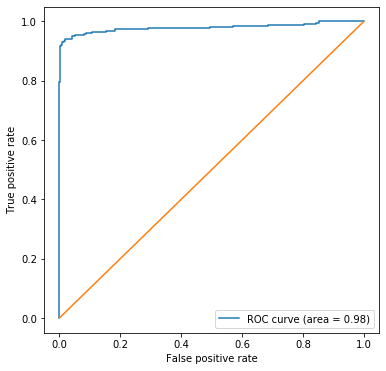

In [29]:
from sklearn import metrics
from matplotlib import pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

### Score distribution <a class="anchor" id="4b"></a>

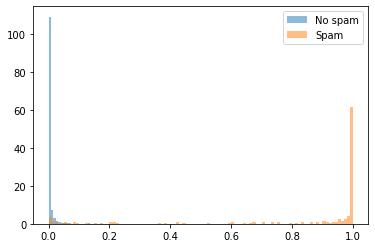

In [30]:
h1 = plt.hist(y_pred[y_test.T[0] == 0], bins=100, density=True, alpha=.5, label="No spam")
h2 = plt.hist(y_pred[y_test.T[0] == 1], bins=100, density=True, alpha=.5, label="Spam")
plt.legend()

In [54]:
y_pred[y_test.T[0] == 1]

261

### Conclusion <a class="anchor" id="5"></a>

Congratulations on completing this notebook! You now have a much better understanding of how NLP works on C3.

## Make sure to CLOSE AND HALT  (from bottom of the File menu) this notebook when you leave.

## Appendix - Kernel Installation Instructions <a class="anchor" id="apdx">
    
If the `Python 3` kernel is not available, perform the following:
1. Select the 'Kernel' tab at the top of this notebook, then select 'Manage Kernels';
2. Scroll to find `Python 3`, and click the 'Install' button;
> Note: This installation will "fail", but don't worry, exit the Manage Kernels UI and return to the main notebook.
3. Navigate to the 'File' tab located at the top of the notebook, and select 'Close and Halt'. This will close the notebook. Re-open it.
4. You should notice, in the upper-right corner, the kernel is now set correctly to `Python 3`. If it is not, navigate to the Kernel tab, then select 'Change Kernel' and select the appropriate option.